In [45]:
using PyPlot
using Random
using Distributions

In [46]:
include("../src/model.jl");
include("../src/ensemble.jl");
include("../src/diagnostics.jl");
include("../src/optimize.jl");
include("../src/plotting.jl");

In [47]:
t = Array(2020:1.:2100);
β = 1.5 # damages (trillion $ / celsius^2)
utility_discount_rate = 0.014 # low value (stern review)
GWP = 100. # global world product (trillion $)
reduce_cost = 0.10*GWP
remove_cost = 0.15*GWP
geoeng_cost = 0.25*GWP
adapt_cost = 0.20*GWP

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0.,
    baseline_emissions(t)
)

Economics(1.5, 0.014, 10.0, 15.0, 25.0, 20.0, 0.0, 0.0, 0.0, 0.0, [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0  …  1.125, 1.0, 0.875, 0.75, 0.625, 0.5, 0.375, 0.25, 0.125, 0.0])

In [48]:
ECS₀ = 1.2
ECS= ECS₀ ./ (1. .-0.65);

In [49]:
ensemble = Dict{String, ClimateModel}();

name = "2020";
controls = init_linear_controls(t);
present_year = 2020.

model = ClimateModel(name, ECS, t, controls, economics, present_year);

In [50]:
optimize!(model)
ensemble[model.name] = model;

Converged after 501 iterations. Converged after 501 iterations. 

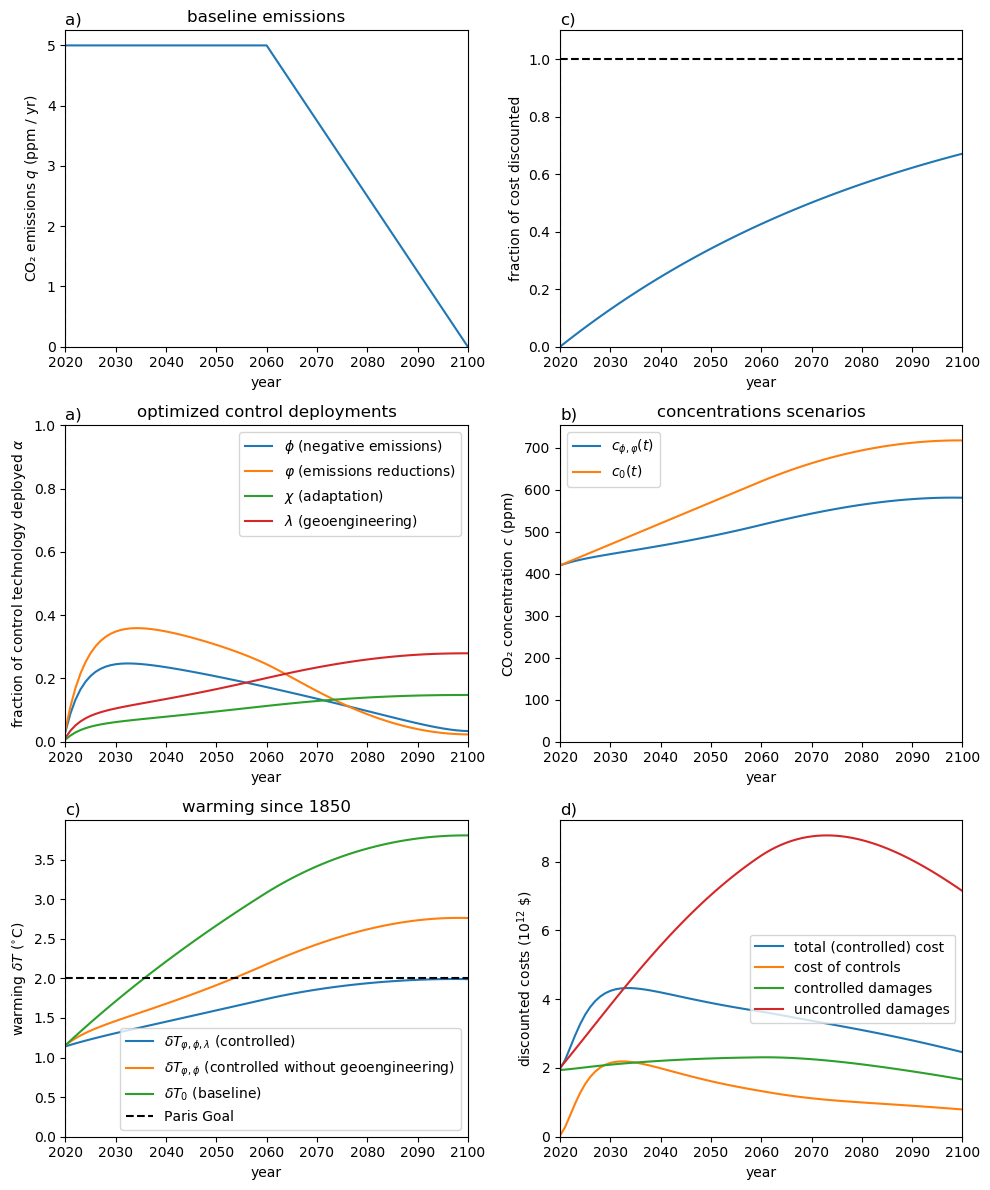

In [51]:
plot_state(model)

In [52]:
function step_forward(model::ClimateModel, Δt::Float64, q0::Float64, t0::Float64, Δt0::Float64)

    present_year = deepcopy(model.present_year) + Δt
    present_idx = deepcopy(argmin(abs.(model.domain .- present_year)))
    name = string(Int64(round(present_year)));
    
    controls = Controls(
        deepcopy(model.controls.reduce),
        deepcopy(model.controls.remove),
        deepcopy(model.controls.geoeng),
        deepcopy(model.controls.adapt)
    )
    
    new_emissions = zeros(size(model.domain))
    new_emissions[model.domain .< model.present_year] = deepcopy(model.economics.baseline_emissions)[model.domain .< model.present_year]
    new_emissions[model.domain .>= model.present_year] = deepcopy(baseline_emissions(model.domain, q0, t0, Δt0))[model.domain .>= model.present_year]
    #new_emissions = deepcopy(baseline_emissions(model.domain, q0, t0, Δt0))
    
    economics = Economics(
        β, utility_discount_rate,
        reduce_cost, remove_cost, geoeng_cost, adapt_cost,
        0., 0., 0., 0.,
        new_emissions
    )
    model = ClimateModel(
        model.name, model.ECS, model.domain, controls, economics, present_year,
    );
    return model
end

step_forward(model::ClimateModel, Δt::Float64, q0::Float64) = step_forward(model::ClimateModel, Δt::Float64, q0::Float64, 2060., 40.)
step_forward(model::ClimateModel, Δt::Float64) = step_forward(model::ClimateModel, Δt::Float64, 5., 2060., 40.)

step_forward (generic function with 3 methods)

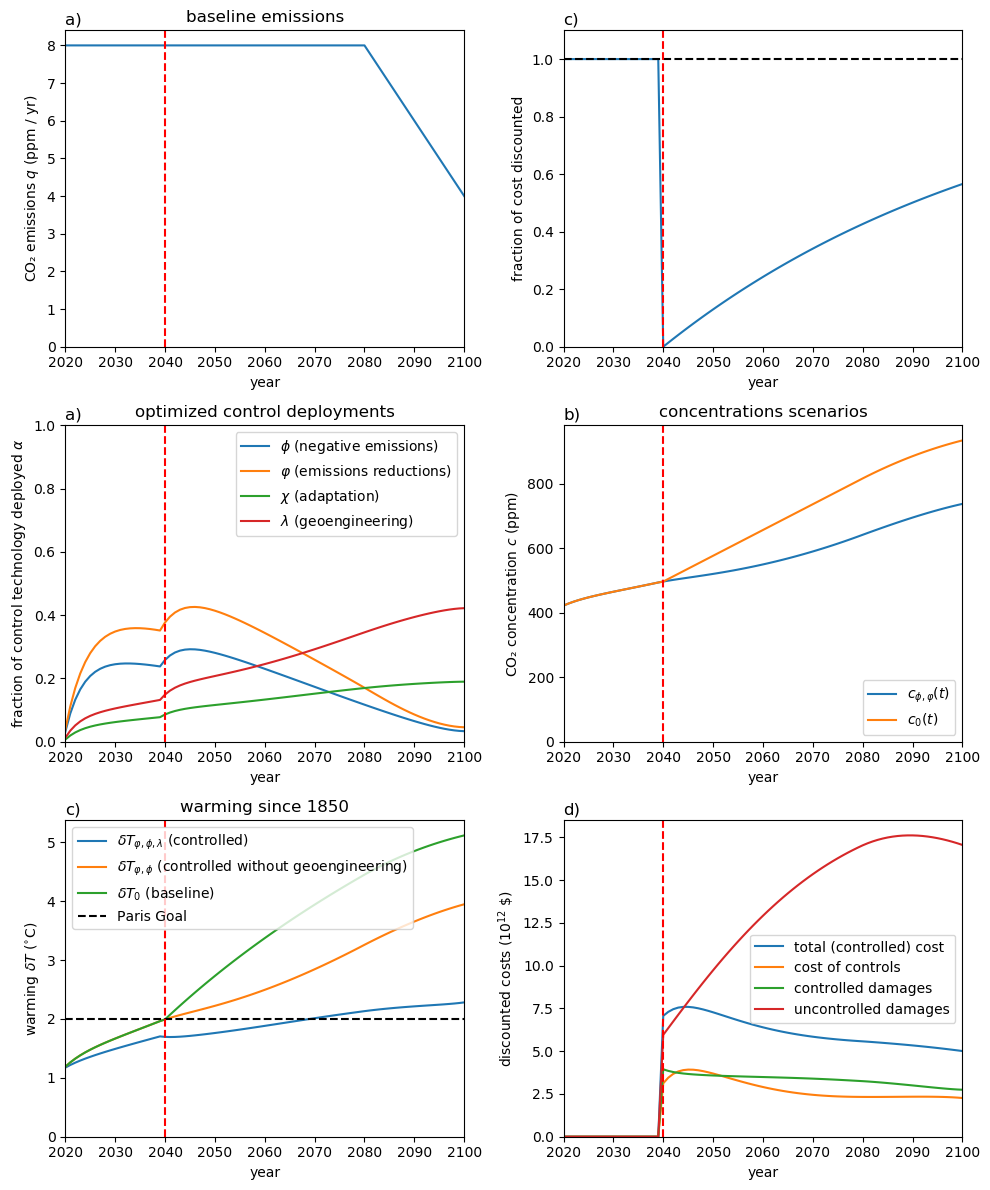

Converged after 501 iterations. Converged after 501 iterations. 

In [53]:
model = step_forward(model, 20., 8., 2080., 40.)
optimize!(model)
plot_state(model)
ensemble[model.name] = model;

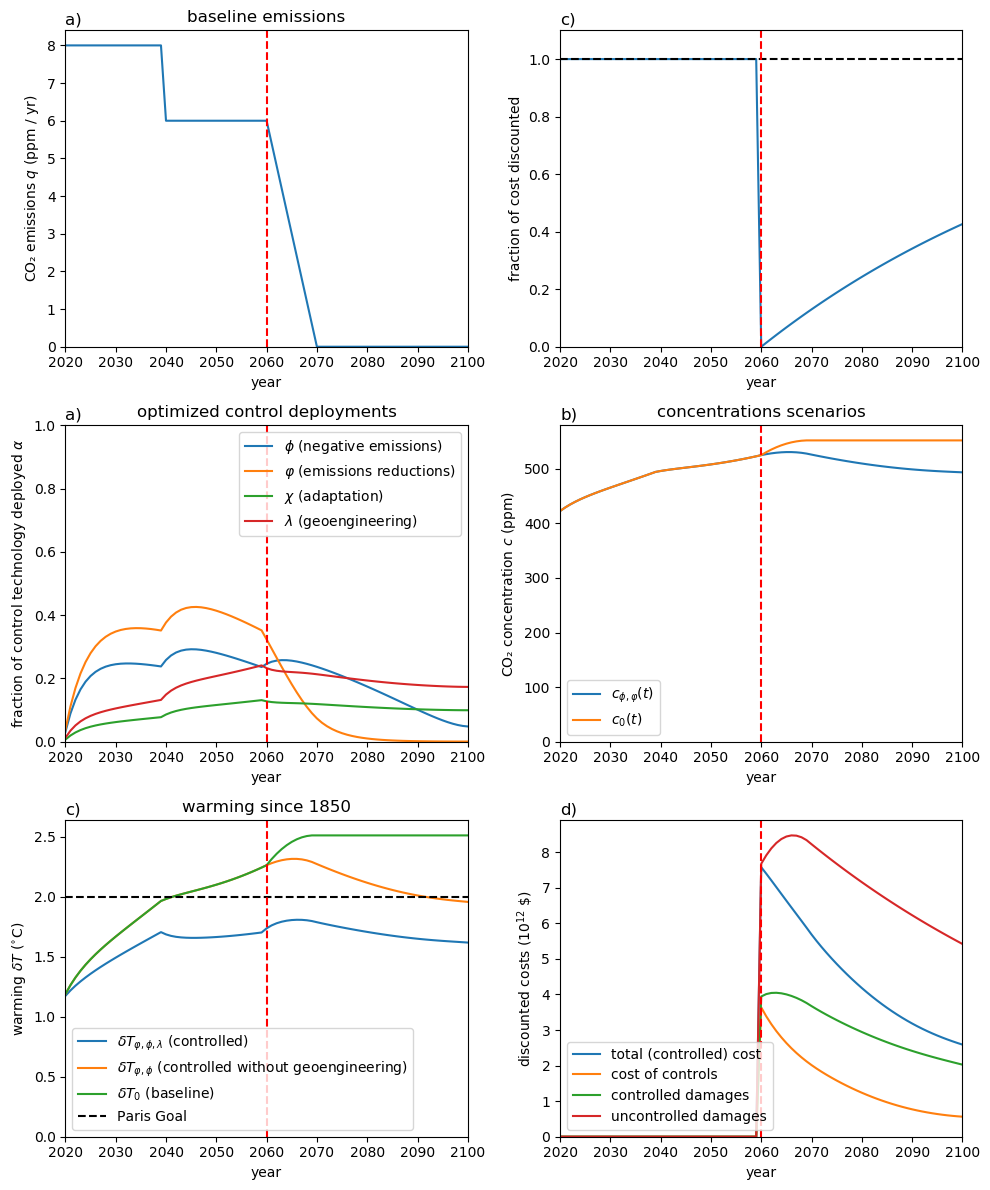

Converged after 501 iterations. Converged after 501 iterations. 

In [54]:
model = step_forward(model, 20., 6., 2060., 10.)
optimize!(model)
plot_state(model)
ensemble[model.name] = model;